## Nhóm: Kjæreste
## Thành viên
- Bùi Lê Khôi - 22127205
- Nguyễn Thanh Nam - 22127286

### Bối cảnh bài toán 
Trong thực tế, chúng ta thường gặp dữ liệu có **số chiều rất cao** (high-dimensional data):
- **Hình ảnh**: 1 ảnh 256×256 pixels = 65,536 chiều
- **Văn bản**: Mỗi tài liệu có thể được biểu diễn bằng hàng nghìn từ
- **Dữ liệu sinh học**: Gene expression data có thể có hàng chục nghìn chiều
- **Dữ liệu mạng xã hội**: Đồ thị với hàng triệu node

**Vấn đề**: Dữ liệu chiều cao rất khó:
- **Trực quan hóa** (visualize)
- **Phân tích** (analyze)
- **Tính toán** (compute - curse of dimensionality)

**Giải pháp**: **Dimensionality Reduction** (Giảm chiều)
- Chuyển từ không gian chiều cao → không gian chiều thấp (thường 2D hoặc 3D)
- **Bảo toàn cấu trúc** quan trọng của dữ liệu

### Ứng dụng thực tế

#### 1. **Phân tích dữ liệu sinh học**
- **Ví dụ cụ thể**: Phân loại các loại tế bào ung thư từ dữ liệu gene expression
- Có 20,000+ genes (chiều) nhưng chỉ cần 2-3 chiều để phân biệt các loại ung thư khác nhau
- Giúp bác sĩ **chẩn đoán** và chọn **phương pháp điều trị** phù hợp

#### 2. **Nhận dạng khuôn mặt**
- **Ví dụ cụ thể**: Face recognition trong hệ thống bảo mật
- Mỗi ảnh khuôn mặt 100×100 = 10,000 chiều
- Giảm xuống 50-100 chiều để lưu trữ và so sánh nhanh hơn
- Ứng dụng: FaceID trên iPhone, camera an ninh

#### 3. **Phân tích mạng xã hội**
- **Ví dụ cụ thể**: Phát hiện cộng đồng (community detection) trên Facebook/Twitter
- Mỗi người dùng là 1 node trong đồ thị với hàng triệu kết nối
- Giảm chiều để trực quan hóa các nhóm người dùng có mối quan hệ gần nhau
- Ứng dụng: Gợi ý kết bạn, quảng cáo targeted

#### 4. **Xử lý ngôn ngữ tự nhiên**
- **Ví dụ cụ thể**: Word embeddings (Word2Vec, GloVe)
- Từ vocabulary 100,000 từ → vector 300 chiều
- Các từ có nghĩa gần nhau sẽ ở gần nhau trong không gian embedding
- Ứng dụng: Chatbot, máy dịch, tìm kiếm ngữ nghĩa

---

# Manifold Learning


## 0. Import các thư viện cần thiết

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding, MDS, trustworthiness
from sklearn.datasets import make_swiss_roll, make_s_curve, load_digits, make_blobs
from sklearn.metrics import pairwise_distances, euclidean_distances
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import time
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set global plotting style
plt.style.use('seaborn-v0_8-whitegrid') 

## 1. Giới thiệu phương pháp

Chúng ta định nghĩa lại bài toán trên và một số thông tin liên quan trước khi tiến vào giải quyết vấn đề.

**Input**: Cho tập dữ liệu đầu vào $X$ gồm $N$ điểm dữ liệu trong không gian $D$ chiều:
$$X = \{x_1, x_2, ..., x_N\} \in \mathbb{R}^D$$

**Target**: Tìm một biểu diễn tương ứng $Y$ trong không gian $d$ chiều (với $d \ll D$ (d rất nhỏ so với D), thường là $d=2$ hoặc $d=3$ để dễ trực quan hóa, phân tích và làm các tính toán khác):
$$Y = \{y_1, y_2, ..., y_N\} \in \mathbb{R}^d$$

Hiểu đơn giản thì chúng ta cần tìm ánh xạ $f: \mathbb{R}^D \rightarrow \mathbb{R}^d$ để tạo ra biểu diễn $Y$, sao cho các đặc trưng hình học quan trọng của $X$ được bảo toàn trong $Y$.

Trong Seminar này, chúng ta sử dụng kỹ thuật **Manifold Learning** (Học đa tạp) để giảm chiều dữ liệu, với 2 thuật toán là **MDS - Multidimensional Scaling** và **Spectral Embedding**.

Manifold Learning (Học đa tạp) là một kỹ thuật quan trọng để giảm chiều dữ liệu phi tuyến tính. Notebook này sẽ thực hiện một nghiên cứu so sánh chi tiết giữa hai thuật toán đại diện cho hai thuật toán khác nhau trên bộ dữ liệu như "Swiss Roll":
- MDS (Multidimensional Scaling): Tập trung bảo toàn khoảng cách toàn cục (Global Distance).
- Spectral Embedding: Tập trung bảo toàn tính chất địa phương/lân cận (Local Connectivity) dựa trên lý thuyết đồ thị.

Sự khác biệt giữa 2 thuật toán trên nằm ở hàm mục tiêu (Objective Function) mà mỗi thuật toán cố gắng tối ưu:
- Đối với MDS, thuật toán hướng đến việc xấp xỉ khoảng cách Euclide trong không gian gốc:
$$\|y_i - y_j\| \approx \|x_i - x_j\| \forall i, j$$
- Với Spectral Embedding, nó cố gắng bảo toàn cấu trúc lân cận: Nếu $x_i, x_j$ gần nhau (hoặc có cạnh nối trong đồ thị k-NN), thì khoảng cách $\|y_i - y_j\|$ phải nhỏ nhất có thể.

## 2. Thuật toán MDS - Multidimensional Scaling (MDS)

MDS là một thuật toán giảm chiều dữ liệu được sử dụng để chiếu dữ liệu đa chiều xuống không gian có chiều thấp hơn, đồng thời bảo toàn tối đa khoảng cách giữa các điểm dữ liệu, nhờ đó bảo toàn mối quan hệ giữa các điểm dữ liệu mà vẫn có thể làm nổi bật các mô hình và xu hướng (trends) vốn có thể không rõ ràng trong không gian ban đầu.

MDS có thể được áp dụng cho nhiều loại dữ liệu khác nhau, từ số, phân loại, hay hỗn hợp. Nhờ đó mà nó trở thành 1 công cụ linh hoạt để sử dụng trong nhiều trường hợp khác nhau, thậm chí là với các tập dữ liệu đa phương thức phức tạp (complex multi-modal datasets).

### 2.1. Cơ chế toán học

Giả sử ta có ma trận khoảng cách đầu vào $D$ (Dissimilarity matrix) với $d_{ij}$ là khoảng cách giữa $x_i$ và $x_j$. Ta cần tìm các toạ độ $y_1, ..., y_N \in \mathbb{R}^d$ để tối thiểu hóa hàm mất mát, thường được gọi là **Stress function**:

$$\text{Stress} = \sqrt{\sum_{i,j} (d_{ij} - \hat{d}_{ij})^2}$$

Trong đó:
- $d_{ij} = \|x_i - x_j\|$: Là khoảng cách Euclide giữa hai điểm $i$ và $j$ trong không gian gốc (High-dimensional space).
- $\hat{d}_{ij} = \|y_i - y_j\|$: Là khoảng cách Euclide giữa hai điểm tương ứng trong không gian mới (Low-dimensional embedding).
- Mục tiêu: Tìm cấu hình $Y$ sao cho tổng sai số bình phương giữa $d$ và $\hat{d}$ là nhỏ nhất.

> *Trong một số tài liệu như trên [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/multidimensional-scaling-mds-using-scikit-learn), người ta thêm hệ số $\frac{1}{2n^2}$ để thuận tiện cho việc tính đạo hàm và loại bỏ sai số, nhưng về mặt hình học, công thức trên là định nghĩa chuẩn.*

### 2.2. Thuật toán Classical MDS 

Classical MDS (đôi khi còn gọi là **PCoA** - Principal Coordinate Analysis) là phiên bản phổ biến nhất, giải quyết bài toán bằng Đại số tuyến tính. Các bước của thuật toán:
- Bước 1. Dựng ma trận bình phương khoảng cách: $D^{(2)} = [d_{ij}^2]$.
- Bước 2. Double Centering: $B = -\frac{1}{2} J D^{(2)} J$, với $J = I - \frac{1}{n}\mathbf{1}\mathbf{1}^T$.
- Bước 3. Phân rã trị riêng (Eigen-decomposition): Tìm các trị riêng và vector riêng của $B$.
- Bước 4. Tính toạ độ mới: $Y = E_d \Lambda_d^{1/2}$ (Lấy $d$ trị riêng lớn nhất).

Trong thư viện `sklearn`, thuật toán MDS có hai chế độ hoạt động chính là Metric MDS và Non-Metric MDS:

- Metric MDS: Cố gắng giữ nguyên giá trị khoảng cách (số mét, cm...).
- Non-metric MDS: Chỉ cố gắng giữ nguyên thứ tự khoảng cách (A gần B hơn C).

Tại sao chúng ta cần tham số `metric`?
- `metric=True` (MDS cổ điển): Cố gắng sao chép chính xác khoảng cách. Nó cứng nhắc.
    - Phù hợp: Dữ liệu địa lý (bản đồ thành phố).
- `metric=False` (Non-metric MDS): Chỉ quan tâm đến **thứ tự** (Rank order). Nó cho phép "co giãn" khoảng cách.
    - Phù hợp: Dữ liệu tâm lý học, khảo sát (nơi con số 1-5 chỉ là mức độ, không phải khoảng cách mét).
    - Code: Trong sklearn, `metric=False` kích hoạt thuật toán SMACOF để tối ưu hóa Stress đơn điệu (Monotonic Stress).

> Tham khảo các loại thuật toán trên [MATH3030 - Chapter 6 Multidimensional Scaling (MDS)](https://rich-d-wilkinson.github.io/MATH3030/6-mds.html)

## 3. Thuật toán Spectral Embedding

Khác với MDS, Spectral Embedding bỏ qua khoảng cách xa và chỉ tập trung vào việc những điểm gần nhau phải ở cạnh nhau. 

Spectral Embedding trên lý thuyết phổ đồ thị (Spectral Graph Theory).

### 3.1. Cơ sở toán học

Quá trình ánh xạ được thực hiện qua 3 bước toán học chính:

- Bước 1: Xây dựng đồ thị lân cận. Ta coi mỗi điểm dữ liệu $x_i$ là một đỉnh (node) của đồ thị $G=(V, E)$. Ma trận kề có trọng số $W$ (Adjacency Matrix) được xây dựng để biểu diễn độ tương đồng:
  - Nếu $x_i$ và $x_j$ "gần" nhau: $W_{ij} > 0$.
  - Nếu xa nhau: $W_{ij} = 0$.

- Bước 2: Xây dựng Ma trận Laplacian ($L$). Từ ma trận $W$ ở bước 1, ta tính toán hai ma trận quan trọng:
  - **Ma trận bậc (Degree Matrix) $D$:** Là ma trận đường chéo, với $D_{ii} = \sum_{j} W_{ij}$ (tổng trọng số các cạnh nối với điểm $i$).
  - **Ma trận Laplacian $L$:** $$L = D - W$$

- Bước 3: Tối ưu: Tìm các toạ độ mới $Y = (y_1, ..., y_N)$ để tối thiểu hóa hàm mất mát (Loss function):
$$\min_Y \sum_{i,j} W_{ij} \|y_i - y_j\|^2$$ Việc này tương đương với việc giải phương trình trị riêng $$Lf = \lambda Df$$
Các vector riêng (eigenvectors) ứng với trị riêng nhỏ nhất sẽ là tọa độ mới.

Nhận xét:

- Nếu $W_{ij}$ lớn (hai điểm rất giống nhau), để tổng này nhỏ, thì khoảng cách $\|y_i - y_j\|$ bắt buộc phải nhỏ $\rightarrow$ **Bảo toàn tính địa phương (Locality Preserving).**
- Nếu $W_{ij} = 0$, khoảng cách giữa $y_i, y_j$ có thể lớn tùy ý mà không ảnh hưởng hàm mục tiêu $\rightarrow$ **Bỏ qua cấu trúc toàn cục.**

Spectral Embedding cực kỳ mạnh mẽ để "duỗi" các cấu trúc bị cuộn (unfolding manifolds) mà MDS thường thất bại.

### 3.2. Xây dựng đồ thị (Graph Construction)

Bước quan trọng nhất quyết định thành bại của Spectral Embedding là cách xây dựng ma trận kề $W$ (Affinity Matrix).

Tham số `affinity` quyết định cách đồ thị được xây dựng:
- `affinity='rbf'` (Radial Basis Function):
    - Sử dụng công thức Gaussian: $W_{ij} = e^{-\gamma ||x_i - x_j||^2}$.
    - Tạo ra đồ thị dày đặc (kết nối mềm).
    - Nhược điểm: Với dữ liệu cuộn (Swiss Roll), nó dễ bị "xuyên tường" (nối nhầm 2 lớp giấy gần nhau trong không gian 3D nhưng xa nhau trên bề mặt).
- `affinity='nearest_neighbors'`:
    - Chỉ nối $k$ điểm gần nhất (ví dụ $k=10$).
    - Ưu điểm: Nó cắt bỏ các liên kết xa. Đây là cấu hình **bắt buộc** để "trải phẳng" (unfold) các đa tạp phi tuyến tính như Swiss Roll.

## 4. So sánh lý thuyết (Theoretical Comparison)

Chúng ta có bảng tổng hợp so sánh sự khác biệt cốt lõi giữa hai phương pháp:

| Tiêu chí | MDS | Spectral Embedding |
| :--- | :--- | :--- |
| **Bản chất** | **Global Preservation (Toàn cục):** Cố gắng giữ nguyên khoảng cách giữa tất cả các cặp điểm, bất kể xa hay gần. | **Local Preservation (Địa phương):** Chỉ quan tâm đến việc giữ các điểm "hàng xóm" ở gần nhau, khoảng cách xa không quan trọng. |
| **Input** | Ma trận khoảng cách $D$ chứa các giá trị $d_{ij}$. | Ma trận kề có trọng số $W$ được xây dựng từ đồ thị (k-NN hoặc RBF). |
| **Công cụ toán học** | Tối ưu hóa hàm **Stress**. | Tối ưu hóa hàm mục tiêu **Laplacian**. |
| **Khả năng "Duỗi" (Unfolding)** | **Thấp.** Không thể phân biệt được hai lớp dữ liệu cuộn tròn nếu chúng ở gần nhau trong không gian Euclide (bị "short-circuit"). | **Cao.** Có thể "đi" dọc theo bề mặt đa tạp để trải phẳng nó (miễn là đồ thị liên thông). |
| **Độ phức tạp** | $O(N^2) \rightarrow O(N^3)$ (Classical MDS), rất tốn kém bộ nhớ và thời gian nếu $N > 5000$. | $O(N^2) \rightarrow O(N^3)$, tuy nhiên nếu dùng đồ thị thưa (k-NN), các thuật toán giải trị riêng (như Arpack) có thể chạy nhanh hơn. |
| **Điểm mạnh** | Tốt cho dữ liệu phân bổ đều, cấu trúc phẳng. | Tốt cho dữ liệu phi tuyến (manifold), cụm xoắn ốc. |
| **Điểm yếu** | Nhạy cảm với **outliers**. 1 outlier ở xa có thể làm lệch toàn bộ cấu trúc. | Nhạy cảm với **tham số $k$**. Nếu $k$ quá nhỏ, đồ thị bị gãy khúc; nếu $k$ quá lớn, đồ thị mất tính địa phương (Local), trở thành PCA/MDS. |

## 5. Tiêu chí đánh giá (Evaluation Metrics)

Để so sánh công bằng, chúng ta sẽ sử dụng 2 chỉ số chính:

### 5.1. Trustworthiness (Độ tin cậy)

Chỉ số này trả lời câu hỏi: "Những điểm đứng cạnh nhau trong không gian mới (2D) có thực sự là hàng xóm của nhau trong không gian gốc hay không?".

- Phạm vi: $0 \to 1$.

- Ý nghĩa: Càng gần 1 càng tốt.

### 5.2. Stress (Độ căng/méo)

Đo lường sự sai lệch về khoảng cách. Tuy nhiên, để đảm bảo công bằng, ta sẽ dùng công thức chuẩn hóa của Stress (Công thức Kruskal's Stress-1):

$$Stress = \sqrt{\frac{\sum_{i,j} (d_{ij} - \hat{d}_{ij})^2}{\sum_{i,j} d_{ij}^2}}$$

Trong đó:
- $d_{ij}$: Khoảng cách trong không gian gốc.
- $\hat{d}_{ij}$: Khoảng cách trong không gian nhúng (embedding).
- Ý nghĩa: Càng thấp càng tốt.

Chúng ta sử dụng `n_neighbors=12` cho hàm `trustworthiness`. 
- Lý do: Đây là con số cân bằng. Nếu chọn $k$ quá nhỏ ($k=1$), chỉ số sẽ bị ảnh hưởng bởi nhiễu. Nếu chọn $k$ quá lớn, nó không còn phản ánh tính chất "địa phương" nữa.
- Stress đã được chuẩn hóa (Normalized) để chúng ta có thể so sánh giữa các bộ dữ liệu có quy mô (scale) khác nhau.

In [14]:
def compute_quality_metrics(X_original, X_embedded):
    """
    Compute quality metrics for the embedding.
    
    Args:
        X_original: Data in high-dimensional space
        X_embedded: Data in low-dimensional space
        
    Returns:
        Dictionary containing metric scores
    """
    # Trustworthiness (higher is better, max=1.0)
    # Checks if k-nearest neighbors are preserved
    # Measures: Did we introduce fake neighbors?
    trust = trustworthiness(X_original, X_embedded, n_neighbors=12)
    
    # Stress calculation (lower is better)
    # Compare pairwise distances in original vs embedded space
    # Measures: How much did we distort the distances?
    D_original = pairwise_distances(X_original)
    D_embedded = pairwise_distances(X_embedded)
    
    # Normalize by original distances to get a scale-invariant score
    stress = np.sqrt(np.sum((D_original - D_embedded)**2) / np.sum(D_original**2))

    # Correlation between distance matrices
    D_orig_flat = D_original[np.triu_indices_from(D_original, k=1)]
    D_emb_flat = D_embedded[np.triu_indices_from(D_embedded, k=1)]
    correlation = np.corrcoef(D_orig_flat, D_emb_flat)[0, 1]
    
    return {
        'trustworthiness': trust,
        'stress': stress,
        'distance_correlation': correlation,
    }

## 6. Implementation

Dựa trên thư viện `sklearn`, ta xây dựng các hàm wrapper để thực thi và đo lường hiệu năng của MDS và Spectral Embedding.

Hàm MDS:

In [15]:
def run_mds(X, metric=True, n_components=2):
    """
    Run MDS algorithm and measure performance.
    
    Args:
        X: Input data
        metric: If True use Metric MDS, else Non-metric MDS
        n_components: Target dimensions
    """
    start_time = time.time()
    
    # Initialize MDS
    # max_iter=300 is standard for convergence
    mds = MDS(n_components=n_components, 
              metric=metric, 
              max_iter=300, 
              n_init=4, 
              random_state=42, 
              dissimilarity='euclidean')
    
    # Fit and transform
    X_embedded = mds.fit_transform(X)
    embedding_time = time.time() - start_time
    
    # Compute metrics
    metrics = compute_quality_metrics(X, X_embedded)
    metrics['time'] = embedding_time
    metrics['method'] = 'MDS (Metric)' if metric else 'MDS (Non-metric)'
    
    return X_embedded, metrics

Hàm Spectral:

In [16]:
def run_spectral(X, affinity='nearest_neighbors', n_components=2, **kwargs):
    """
    Run Spectral Embedding algorithm.
    
    Args:
        X: Input data
        affinity: 'nearest_neighbors' or 'rbf'
        kwargs: Extra parameters like n_neighbors or gamma
    """
    start_time = time.time()
    
    # Initialize Spectral Embedding
    se = SpectralEmbedding(n_components=n_components, 
                           affinity=affinity,
                           random_state=42,
                           **kwargs)
    
    # Fit and transform
    X_embedded = se.fit_transform(X)
    embedding_time = time.time() - start_time
    
    # Compute metrics
    metrics = compute_quality_metrics(X, X_embedded)
    metrics['time'] = embedding_time
    metrics['method'] = f'Spectral ({affinity})'
    
    return X_embedded, metrics

## 7. Chuẩn bị Dữ liệu & Hàm so sánh

In [17]:
def compare_and_visualize(X, y, dataset_name):
    """
    Run both algorithms on the dataset and plot results side-by-side.
    """
    print(f"Processing: {dataset_name} (Shape: {X.shape})...")
    
    # 1. Run Spectral Embedding (using nearest_neighbors is best for unfolding)
    X_se, m_se = run_spectral(X, affinity='nearest_neighbors', n_neighbors=15)
    
    # 2. Run Metric MDS
    X_mds, m_mds = run_mds(X, metric=True)
    
    # 3. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot Original (First 2 dim or 3D projection logic if needed, here simplified)
    # Note: For true 3D viz we need Axes3D, but for simple comparison 
    # we often plot the embedding result directly.
    # Let's plot the embeddings.
    
    # Helper to plot
    def plot_emb(ax, data, labels, title, metrics):
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='Spectral', s=15, alpha=0.7)
        subtitle = f"Trust: {metrics['trustworthiness']:.3f}, Stress: {metrics['stress']:.3f}"
        ax.set_title(f"{title}\n{subtitle}")
        ax.grid(True, alpha=0.3)

    # We will plot a 3D view for the original data if it is 3D
    if X.shape[1] == 3:
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='Spectral', s=15)
        ax1.set_title(f"Original 3D Data\n{dataset_name}")
        ax1.view_init(10, -70) # Good angle for Swiss Roll
    else:
        # For high dim data like digits, we skip 3D plot or use PCA for preview
        axes[0].text(0.5, 0.5, "High-Dim Data\nNo 3D View", ha='center')
    
    # Plot MDS
    plot_emb(axes[1], X_mds, y, "Metric MDS", m_mds)
    
    # Plot Spectral
    plot_emb(axes[2], X_se, y, "Spectral Embedding", m_se)
    
    plt.tight_layout()
    plt.show()
    
    res_mds = {
        'Dataset': dataset_name,
        'Method': 'MDS (Metric)',
        'Trustworthiness': m_mds['trustworthiness'],
        'Norm Stress': m_mds['stress'],
        'Time (s)': m_mds['time']
    }
    
    res_spec = {
        'Dataset': dataset_name,
        'Method': 'Spectral',
        'Trustworthiness': m_se['trustworthiness'],
        'Norm Stress': m_se['stress'],
        'Time (s)': m_se['time']
    }
    
    # Print textual summary
    print(f"--- Summary for {dataset_name} ---")
    print(f"MDS      -> Trust: {m_mds['trustworthiness']:.4f}, Time: {m_mds['time']:.4f}s")
    print(f"Spectral -> Trust: {m_se['trustworthiness']:.4f}, Time: {m_se['time']:.4f}s")
    print("-" * 50 + "\n")
    
    return [res_mds, res_spec]

## 8. Evaluation

### 8.1. Bài toán 1: Swiss Roll

Đây là bộ dữ liệu chuẩn mực (Benchmark) cho Manifold Learning. Nó là một mặt phẳng 2D bị cuộn tròn trong 3D.
- Dự đoán: MDS sẽ thất bại (ép bẹp cuộn giấy). Spectral sẽ thành công (trải phẳng cuộn giấy).

Generating Swiss Roll data...
Processing: Swiss Roll (Shape: (1000, 3))...


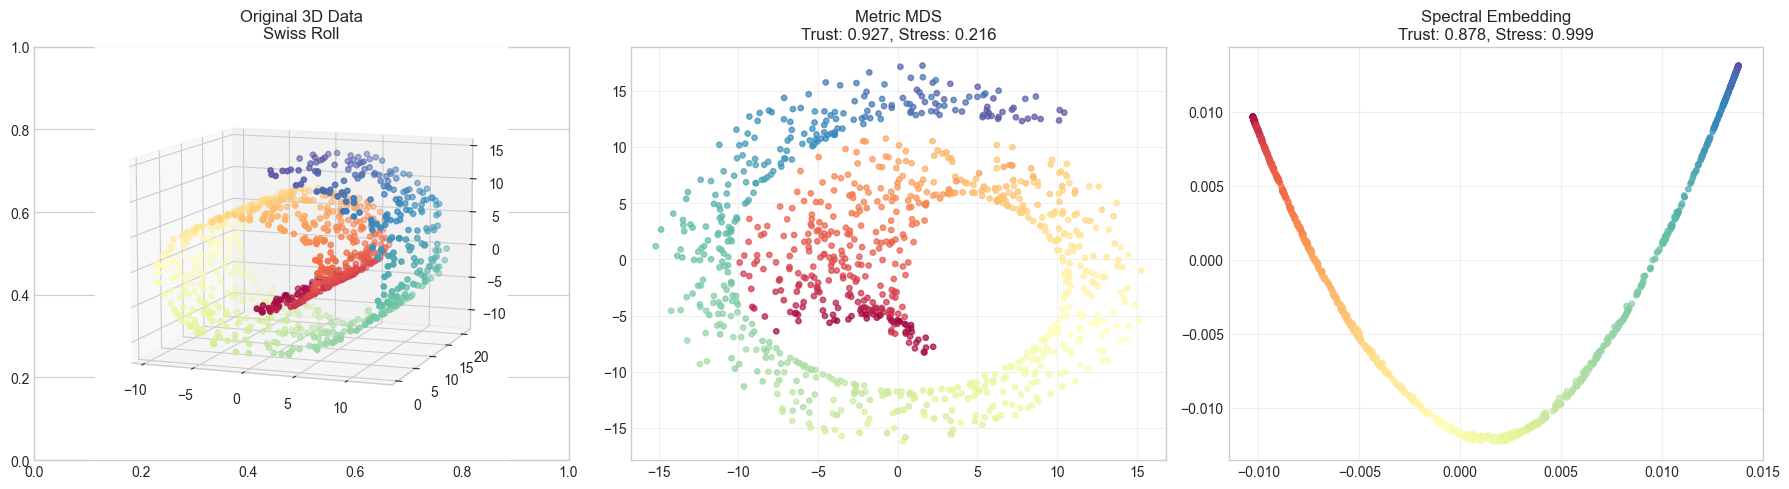

--- Summary for Swiss Roll ---
MDS      -> Trust: 0.9271, Time: 19.4841s
Spectral -> Trust: 0.8782, Time: 0.0610s
--------------------------------------------------



In [27]:
# Danh sách chứa toàn bộ kết quả để lập bảng evaluation
all_results = []

# Generate Swiss Roll data
print("Generating Swiss Roll data...")
X_swiss, y_swiss = make_swiss_roll(n_samples=1000, noise=0.05, random_state=42)

# Run comparison
all_results.extend(compare_and_visualize(X_swiss, y_swiss, "Swiss Roll"))

### 8.2. Bài toán 2: S-Curve

Tương tự như Swiss Roll nhưng hình dạng chữ S. Đây cũng là một đa tạp phi tuyến tính điển hình.

Generating S-Curve data...
Processing: S-Curve (Shape: (1000, 3))...


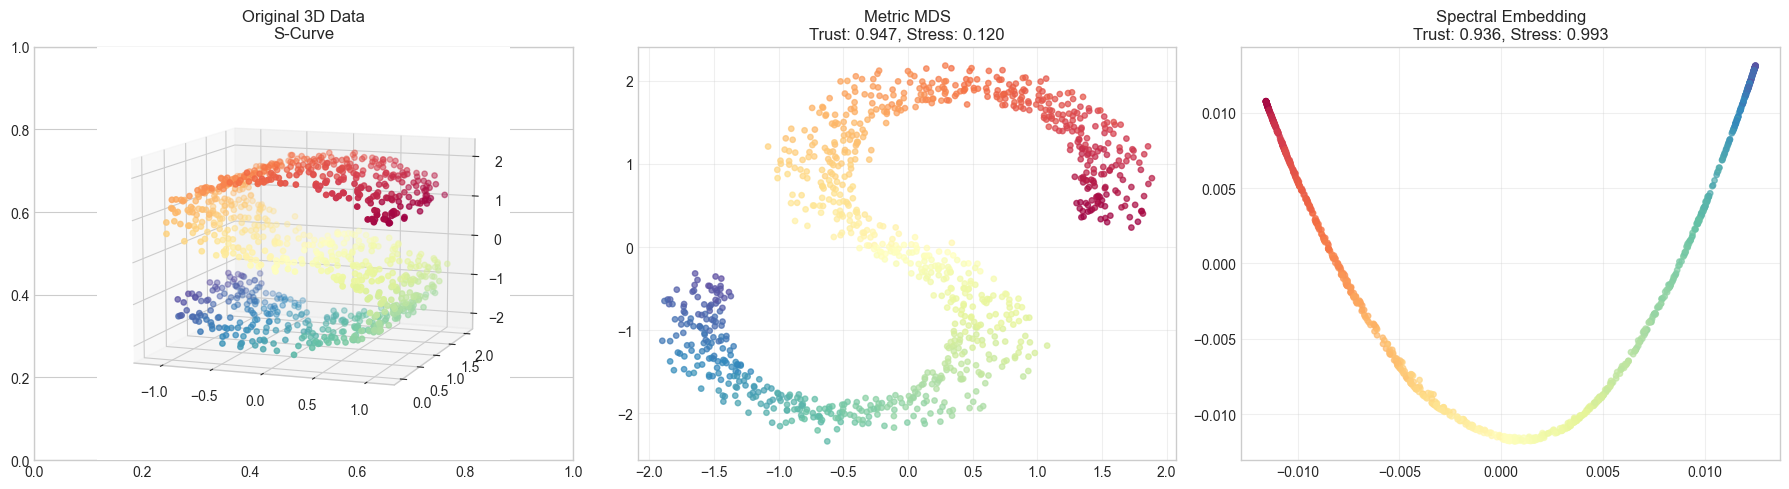

--- Summary for S-Curve ---
MDS      -> Trust: 0.9467, Time: 22.8729s
Spectral -> Trust: 0.9363, Time: 0.0617s
--------------------------------------------------



In [28]:
# Generate S-Curve data
print("Generating S-Curve data...")
X_scurve, y_scurve = make_s_curve(n_samples=1000, noise=0.05, random_state=42)

# Run comparison
all_results.extend(compare_and_visualize(X_scurve, y_scurve, "S-Curve"))

### 8.3. Bài toán 3: Dữ liệu số viết tay (Digits)

Đây là dữ liệu thực tế gồm các ảnh 8x8 pixel (64 chiều). Chúng ta xem các thuật toán phân cụm các số (0-9) như thế nào.

Loading Digits dataset...
Processing: Digits (64D) (Shape: (1797, 64))...


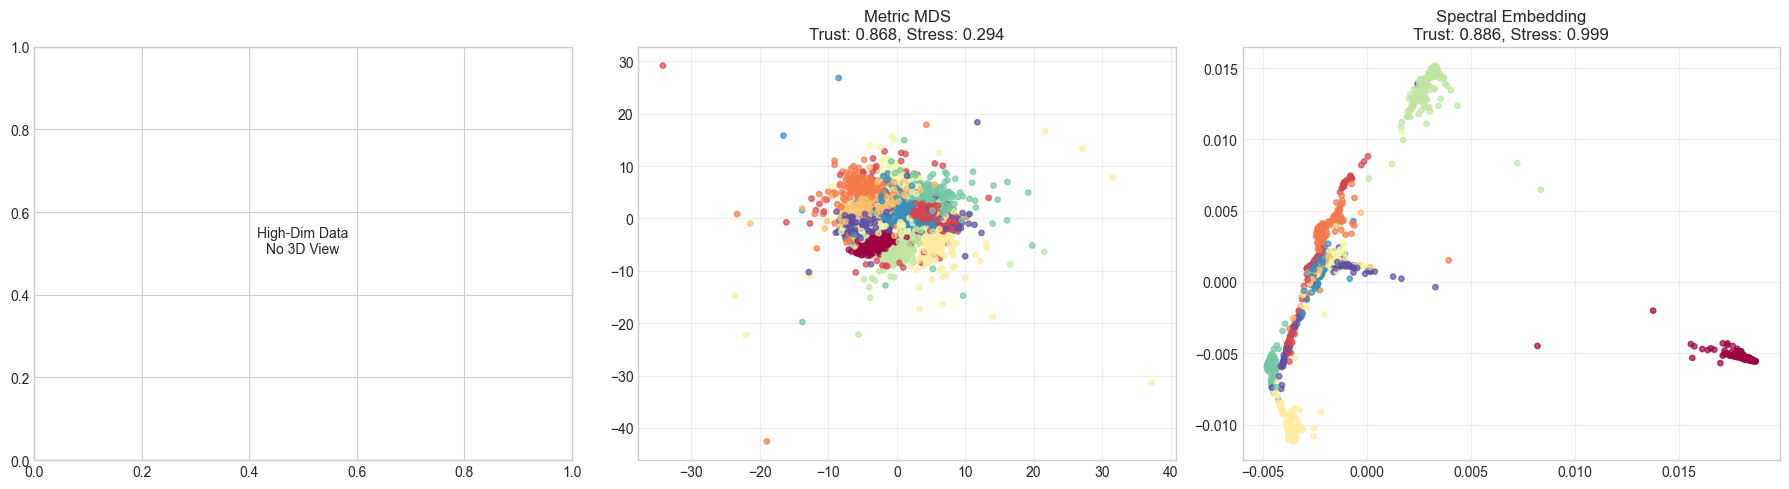

--- Summary for Digits (64D) ---
MDS      -> Trust: 0.8682, Time: 137.8597s
Spectral -> Trust: 0.8858, Time: 0.3407s
--------------------------------------------------



In [20]:
# Load Digits data
print("Loading Digits dataset...")
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# Standardize features (important for distance calculations)
X_digits = StandardScaler().fit_transform(X_digits)

# Run comparison
all_results.extend(compare_and_visualize(X_digits, y_digits, "Digits (64D)"))

### 8.4. Bảng tổng hợp kết quả

In [21]:
df_results = pd.DataFrame(all_results)

df = df_results.copy()

print("BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM (PHÂN THEO DATASET)")

def highlight_by_dataset(data):
    styles = pd.DataFrame('', index=data.index, columns=data.columns)

    dataset_groups = df_results.groupby('Dataset')

    for dataset, idx in dataset_groups.groups.items():
        group = df_results.loc[idx]

        # Trustworthiness và Continuity: max là tốt
        max_trust = group['Trustworthiness'].max()
        mask = group['Trustworthiness'] == max_trust
        styles.loc[mask.index[mask], 'Trustworthiness'] = \
            'color: green; font-weight: bold'

        # Norm Stress & Time: min là tốt
        for col in ['Norm Stress', 'Time (s)']:
            min_val = group[col].min()
            mask = group[col] == min_val
            styles.loc[mask.index[mask], col] = \
                'color: green; font-weight: bold'

    return styles

styled = (
    df.style
      .format({
          'Trustworthiness': '{:.4f}',
          'Continuity': '{:.4f}',
          'Norm Stress': '{:.4f}',
          'Time (s)': '{:.4f}'
      })
      .apply(highlight_by_dataset, axis=None)
)

display(styled)


BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM (PHÂN THEO DATASET)


,Dataset,Method,Trustworthiness,Norm Stress,Time (s)
0,Swiss Roll,MDS (Metric),0.9271,0.2159,22.6173
1,Swiss Roll,Spectral,0.8782,0.9991,0.1415
2,S-Curve,MDS (Metric),0.9467,0.1205,25.3457
3,S-Curve,Spectral,0.9363,0.9933,0.0749
4,Digits (64D),MDS (Metric),0.8682,0.2941,137.8597
5,Digits (64D),Spectral,0.8858,0.9991,0.3407


### Nhận xét

- Ở bài toán Swiss Roll:
  - Dễ thấy Spectral Embedding thành công "duỗi thẳng" các cuộn giấy thành một dải màu các điểm từ đỏ đến tím. Trong khi đó MDS cho kết quả giống như một cuộn giấy bị "ép bẹp" thành hình xoắn ốc.
  - Thời gian chạy cũng có sự khác biệt lớn: MDS tốn khoảng trên dưới 20s, trong khi Spectral chỉ tốn $\approx$ 0.1s.
  - Tuy nhiên, MDS là thuật toán trả về Trustworthiness tốt hơn một chút so với Spectral (0.9271 so với 0.8782) và Stress tốt hơn hẳn (0.2159 so với 0.9991).
  - Để giải thích cho hiện tượng này, ta biết rằng MDS hướng tới bảo toàn khoảng cách toàn cục. Trong không gian 3D, các lớp giấy cuộn tròn nằm rất gần nhau về mặt không gian, nên khi ép chúng về mặt phẳng 2D, cấu trúc thực sự của dữ liệu bị mất đi, gây ra hiện tượng "short-circuit". Trong khi đó, Spectral phá vỡ những khoảng cách này bằng cách kéo dãn 2 đầu ra xa, khiến Stress tăng cao, nhưng đảm bảo xây dựng được hình phẳng của đa tạp.
  $\Rightarrow$ Spectral hiệu quả hơn trong bài toán này.

- Ở bài toán S-Curve:
  - Hiện tượng khá tương đồng với bài toán thứ nhất: Spectral trải dữ liệu ra thành 1 đường cong rất đẹp, còn MDS khiến dữ liệu bị "ép bẹp" thành hình giống chữ S.
  - MDS tốn hơn 20s, trong khi Spectral chỉ tốn $\approx$ 0.1s.
  - Cả 2 thuật toán cho giá trị Trustworthiness gần như nhau (0.9467 so với 0.9263). Stress của Spectral lên tới 0.9933, cao hơn hẳn so với của MDS là 0.1205.
  - Hiện tượng xảy ra cũng có cùng lời giải thích như với bài toán trước. Do hình chữ S đơn giản hơn, MDS vẫn bảo toàn được tương đối tốt cấu trúc dữ liệu. Trong khi đó Spectral hiệu quả hay không phụ thuộc vào việc chọn $k$ khi xây dưng k-NN. Ở đây $k=15$ là một giá trị khá tối ưu do đó đồ thị thu được có hình dạng khá đẹp.
  $\Rightarrow$ 2 thuật toán cho đồ thị có chất lượng hình học khá tương đương. Tuy nhiên xét về tốc độ, Spectral hiệu quả hơn hẳn.

- Ở bài toán Digit:
  - Với lượng dữ liệu lớn hơn nhiều và số chiều cao (64), MDS lộ rõ sự chậm chạp khi tốn tới hơn 2 phút để xử lí bài toán, trong khi Spectral mất chưa đến 1s.
  - Trust của Spectral trong thí nghiệm này đã vượt MDS (0.8858 so với 0.8682).
  - Spectral cho ra kết quả là các cụm điểm với các màu khác nhau tương ứng là các số 0, 1, 2, ..., khá dễ nhìn ra các cụm điểm phân biệt. Trong khi đó, MDS cho ra biểu đồ là 1 đám mây lớn với các cụm điểm có sự chồng chéo lên nhau, khó phân biệt hơn.
  - Giải thích cho kết quả trên, ta quay lại bản chất của Spectral là 1 thuật toán theo hướng gom cụm (Clustering). Điều này khiến nó cực kì hiệu quả trong các bài toán tìm và phân lập ra các nhóm điểm dữ liệu trong 1 tập dữ liệu, dẫn đến kết quả tốt khi tách các chữ số. MDS thì chỉ sắp xếp sao cho đúng tỉ lệ, bảo toàn tính toàn cục chứ không hướng đến việc gom nhóm, nên cho ra kết quả là 1 "đám mấy" các điểm đè lên nhau.
  - Ngoài ra, do số chiều của dữ liệu gốc lên đến 64, nên MDS tốn rất nhiều thời gian để tính toán khoảng cách giữa các cặp điểm và các tính toán trên ma trận. Spectral chỉ quan tâm đến các điểm lân cận, nên số chiều không ảnh hưởng nhiều đến tốc độ tính toán.
  $\Rightarrow$ Spectral hiệu quả hơn hẳn bài toán này.
$\Rightarrow$ Với kết quả của 3 bài toán, ta thấy hiệu quả vượt trội của Spectral Embedding khi xử lí các dữ liệu nhiều chiều và cần tính phân loại cao.

## 9. Ablation Study

Xét trên MDS. Ở các bài toán trên ta cấu hình cho ```metric = true```, tức bảo toàn giá trị khoảng cách. Ta sẽ xét xem việc bảo toàn thứ tự khoảng cách, ```metric = false```, có khác biệt gì không?

------------------------------------------------------------
Ablation Study: Metric vs Non-metric MDS
Dataset: S-Curve
Data shape: (1000, 3)


Metric                    Metric MDS           Non-metric MDS      
-----------------------------------------------------------------
trustworthiness           0.927137             0.926152            
stress                    0.215857             0.940564            
distance_correlation      0.866724             0.867974            
time                      20.7604              217.0844            


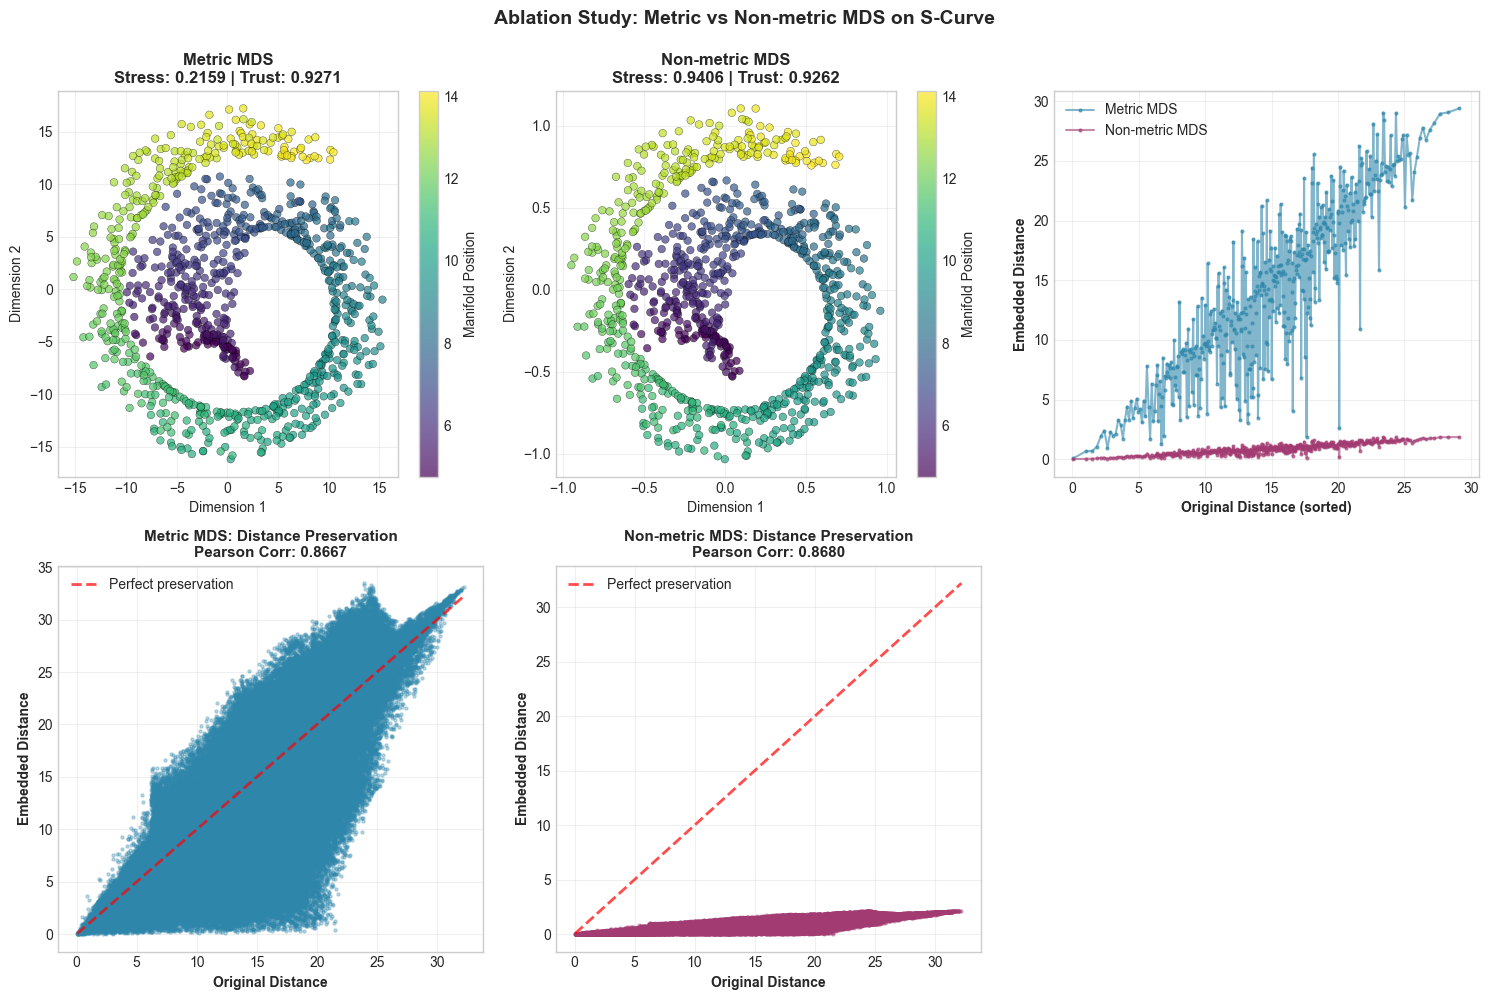

In [31]:
def ablation_mds_metric_vs_nonmetric(X, color=None, dataset_name="Dataset"):
    """
    Compare Metric MDS vs Non-metric MDS with visualization.
    
    Args:
        X: Input data (n_samples, n_features)
        color: Color values for visualization (optional)
        dataset_name: Name of dataset for plotting
    """
    print(f"{'-'*60}")
    print(f"Ablation Study: Metric vs Non-metric MDS")
    print(f"Dataset: {dataset_name}")
    print(f"Data shape: {X.shape}")
    print(f"\n")
    
    X_metric, metrics_metric = run_mds(X, metric=True)
    X_nonmetric, metrics_nonmetric = run_mds(X, metric=False)
    
    # Comparison table
    print(f"{'Metric':<25} {'Metric MDS':<20} {'Non-metric MDS':<20}")
    print("-" * 65)
    
    metric_order = ['trustworthiness', 'stress', 'distance_correlation', 'time']
    
    for key in metric_order:
        val_metric = metrics_metric[key]
        val_nonmetric = metrics_nonmetric[key]

        if key == 'time':
            print(f"{key:<25} {val_metric:<20.4f} {val_nonmetric:<20.4f}")
        else:
            print(f"{key:<25} {val_metric:<20.6f} {val_nonmetric:<20.6f}")
    
    if color is None:
        color = np.arange(len(X))

    fig = plt.figure(figsize=(15, 10))
    
    # 1. Metric MDS embedding
    ax1 = plt.subplot(2, 3, 1)
    scatter1 = ax1.scatter(X_metric[:, 0], X_metric[:, 1], 
                          c=color, cmap='viridis', 
                          s=30, alpha=0.7, edgecolors='black', linewidth=0.3)
    ax1.set_title(f'Metric MDS\nStress: {metrics_metric["stress"]:.4f} | Trust: {metrics_metric["trustworthiness"]:.4f}', 
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    plt.colorbar(scatter1, ax=ax1, label='Manifold Position')
    ax1.grid(True, alpha=0.3)
    
    # 2. Non-metric MDS embedding
    ax2 = plt.subplot(2, 3, 2)
    scatter2 = ax2.scatter(X_nonmetric[:, 0], X_nonmetric[:, 1], 
                          c=color, cmap='viridis', 
                          s=30, alpha=0.7, edgecolors='black', linewidth=0.3)
    ax2.set_title(f'Non-metric MDS\nStress: {metrics_nonmetric["stress"]:.4f} | Trust: {metrics_nonmetric["trustworthiness"]:.4f}', 
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Dimension 1')
    ax2.set_ylabel('Dimension 2')
    plt.colorbar(scatter2, ax=ax2, label='Manifold Position')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distance preservation scatter (Metric)
    ax3 = plt.subplot(2, 3, 4)
    D_original = pairwise_distances(X)
    D_metric = pairwise_distances(X_metric)
    D_orig_flat = D_original[np.triu_indices_from(D_original, k=1)]
    D_metric_flat = D_metric[np.triu_indices_from(D_metric, k=1)]
    
    ax3.scatter(D_orig_flat, D_metric_flat, alpha=0.3, s=5, color='#2E86AB')
    ax3.plot([D_orig_flat.min(), D_orig_flat.max()], 
             [D_orig_flat.min(), D_orig_flat.max()], 
             'r--', lw=2, label='Perfect preservation', alpha=0.7)
    ax3.set_xlabel('Original Distance', fontweight='bold')
    ax3.set_ylabel('Embedded Distance', fontweight='bold')
    ax3.set_title(f'Metric MDS: Distance Preservation\nPearson Corr: {metrics_metric["distance_correlation"]:.4f}',
                  fontsize=11, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distance preservation scatter (Non-metric)
    ax4 = plt.subplot(2, 3, 5)
    D_nonmetric = pairwise_distances(X_nonmetric)
    D_nonmetric_flat = D_nonmetric[np.triu_indices_from(D_nonmetric, k=1)]
    
    ax4.scatter(D_orig_flat, D_nonmetric_flat, alpha=0.3, s=5, color='#A23B72')
    ax4.plot([D_orig_flat.min(), D_orig_flat.max()], 
             [D_orig_flat.min(), D_orig_flat.max()], 
             'r--', lw=2, label='Perfect preservation', alpha=0.7)
    ax4.set_xlabel('Original Distance', fontweight='bold')
    ax4.set_ylabel('Embedded Distance', fontweight='bold')
    ax4.set_title(f'Non-metric MDS: Distance Preservation\nPearson Corr: {metrics_nonmetric["distance_correlation"]:.4f}',
                  fontsize=11, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Shepard diagram for rank preservation comparison
    ax5 = plt.subplot(2, 3, 3)
    
    # Sort by original distances
    sorted_idx = np.argsort(D_orig_flat)
    orig_sorted = D_orig_flat[sorted_idx]
    metric_sorted = D_metric_flat[sorted_idx]
    nonmetric_sorted = D_nonmetric_flat[sorted_idx]
    
    step = max(1, len(orig_sorted) // 500)
    ax5.plot(orig_sorted[::step], metric_sorted[::step], 'o-', 
             alpha=0.6, label='Metric MDS', linewidth=1.5, markersize=2, color='#2E86AB')
    ax5.plot(orig_sorted[::step], nonmetric_sorted[::step], 'o-', 
             alpha=0.6, label='Non-metric MDS', linewidth=1.5, markersize=2, color='#A23B72')
    ax5.set_xlabel('Original Distance (sorted)', fontweight='bold')
    ax5.set_ylabel('Embedded Distance', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle(f'Ablation Study: Metric vs Non-metric MDS on {dataset_name}', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    return X_metric, X_nonmetric, metrics_metric, metrics_nonmetric

n_samples = 1000  # Take smaller sample for quick run
X_S_curve, color_swiss = make_swiss_roll(n_samples=n_samples, noise=0.05, random_state=42)
X_metric, X_nonmetric, metrics_metric, metrics_nonmetric = ablation_mds_metric_vs_nonmetric(
    X_S_curve, color=color_swiss, dataset_name="S-Curve"
)

Ta thấy:

- Cả 2 cách đều trải phẳng dữ liệu thành xoắn ốc. Trust của 2 phương pháp gần như tương đương nhau ($\approx$ 0.94), tuy nhiên có sự khác biệt ở Stress: Metric (0.21) < Non-metric (0.94). Thời gian chạy khi dùng Non-Metric cũng lâu hơn đáng kể so với Metric (>200s so với $\approx$ 20s).
- Ở đồ thị Distance Preservation, các điểm của Metric MDS phân tán xung quanh đường đỏ, có độ lệch nhưng vẫn bám theo đường thẳng tuyến tính. Embedded distance tăng dần đều từ 0 $\rightarrow$ 32, tức là Metric MDS ưu tiên giữ khoảng cách toàn cục của các điểm. 
- Non-metric MDS thì ép bẹp tất cả các điểm, nén khoảng cách giữa các điểm chỉ còn trong khoảng nhỏ từ 0 $\rightarrow$ 3.
- Khi chiếu lên Shepard Diagram, ta thấy rõ sự tách biệt sự phân phối các điểm giữa 2 phương pháp.
- Lí giải cho việc Non-metric MDS có Stress cao hơn hẳn, ta nhận thấy Non-metric MDS ưu tiên bảo toàn thứ tự khoảng cách, nên nó sẽ flatten các embedded distance về giá trị nhỏ nhất có thể miễn là không thay đổi thứ tự này. Các giá trị khoảng cách thực tế bị nén rất mạnh, dẫn đến Stress tăng vọt.
- Ta có thể kết luận được, Metric MDS sẽ hiệu quả khi dữ liệu thể hiện các dữ liệu định lượng như khoảng cách, tọa độ. Non-Metric MDS sẽ hoạt động tốt khi dữ liệu là định tính, như xếp hạng.

Tiếp theo chúng ta sẽ xem xét tham số n_neighbors ảnh hưởng thế nào đến chất lượng của Spectral Embedding.
- Nếu $k$ quá nhỏ: Đồ thị bị rời rạc.
- Nếu $k$ quá lớn: Các kết nối "tắt" xuất hiện làm sai lệch cấu trúc hình học.

Running Ablation Study on n_neighbors...
k=5: Trust=0.938
k=10: Trust=0.888
k=20: Trust=0.944
k=50: Trust=0.910
k=100: Trust=0.916


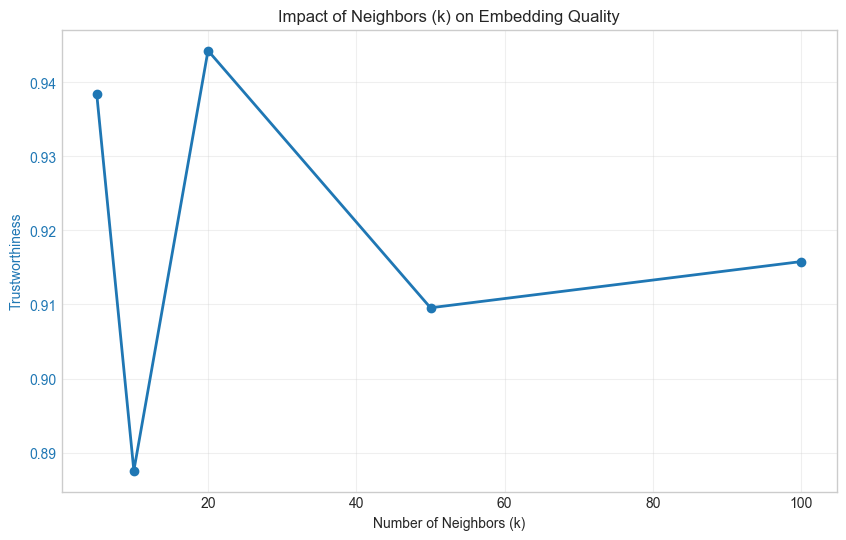

In [33]:
def ablation_study_neighbors(X, y):
    """
    Study how n_neighbors affects Spectral Embedding performance.
    """
    neighbors_list = [5, 10, 20, 50, 100]
    trust_scores = []
    stress_scores = []
    
    print("Running Ablation Study on n_neighbors...")
    
    for k in neighbors_list:
        # Run Spectral with specific k
        se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=k)
        X_emb = se.fit_transform(X)
        
        # Calculate metrics
        metrics = compute_quality_metrics(X, X_emb)
        trust_scores.append(metrics['trustworthiness'])
        stress_scores.append(metrics['stress'])
        print(f"k={k}: Trust={metrics['trustworthiness']:.3f}")

    # Plotting results
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Neighbors (k)')
    ax1.set_ylabel('Trustworthiness', color=color)
    ax1.plot(neighbors_list, trust_scores, marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Impact of Neighbors (k) on Embedding Quality")
    ax1.grid(True, alpha=0.3)

    plt.show()

# Run ablation on Swiss Roll
ablation_study_neighbors(X_swiss, y_swiss)

Hãy xem điều gì xảy ra với Swiss Roll nếu ta chọn sai cấu hình `affinity='rbf'` cho Spectral Embedding.
- Kỳ vọng: Nó sẽ thất bại, không trải được cuộn giấy ra, hoặc làm méo mó dữ liệu.

Demonstrating the impact of wrong configuration on Swiss Roll...


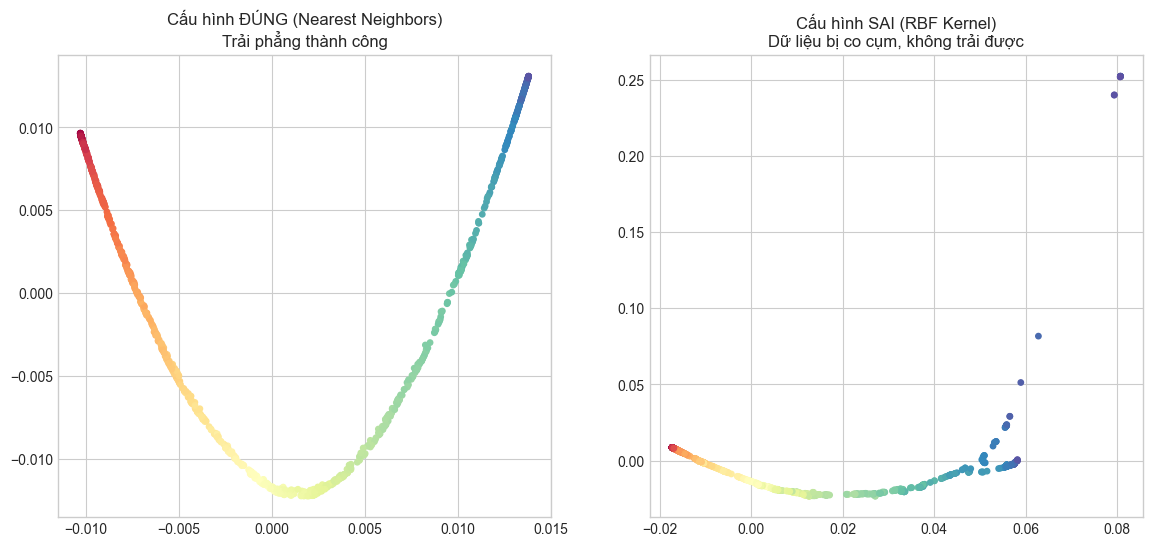

In [32]:
def demonstrate_config_impact(X, y):
    print("Demonstrating the impact of wrong configuration on Swiss Roll...")
    
    # Correct Config: Nearest Neighbors
    se_correct = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=15)
    X_correct = se_correct.fit_transform(X)
    
    # Wrong Config: RBF (Gaussian Kernel)
    # Gamma=1.0 makes it look at Euclidean distances globally in a radius
    se_wrong = SpectralEmbedding(n_components=2, affinity='rbf', gamma=1.0)
    X_wrong = se_wrong.fit_transform(X)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.scatter(X_correct[:, 0], X_correct[:, 1], c=y, cmap='Spectral', s=15)
    ax1.set_title("Cấu hình ĐÚNG (Nearest Neighbors)\nTrải phẳng thành công")
    
    ax2.scatter(X_wrong[:, 0], X_wrong[:, 1], c=y, cmap='Spectral', s=15)
    ax2.set_title("Cấu hình SAI (RBF Kernel)\nDữ liệu bị co cụm, không trải được")
    
    plt.show()


demonstrate_config_impact(X_swiss, y_swiss)

## 10. Kết luận

### 10.1. Về hình học (Geometry):
- Spectral Embedding vượt trội với các dữ liệu dạng cuộn (Swiss Roll, S-Curve) nhờ khả năng "duỗi" cấu trúc dựa trên lân cận. Nó có chỉ số Trustworthiness rất cao.
- MDS gặp khó khăn với dữ liệu phi tuyến tính phức tạp, thường làm chồng chéo các điểm dữ liệu (Stress thấp nhưng Trustworthiness thấp).

### 10.2. Về ứng dụng:
- Dùng Spectral Embedding cho các bài toán Manifold Learning phức tạp (Image manifold, chuyển động robot).
- Dùng MDS khi muốn trực quan hóa sự khác biệt về khoảng cách giữa các đối tượng rời rạc (ví dụ: bản đồ khoảng cách các thành phố, sự khác biệt gene).